In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
import scrapbook as sb

C:\Users\Hakan Serpen\.conda\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'ETH'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'

In [3]:
# Parameters
from_date = "2021-12-01 00:00:00"
to_date = "2021-12-15 00:00:00"
token = "CRV"
connection_string = "sqlite:///data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [5]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [6]:
prices['volatility'] = vol_ohlc(prices,2)


In [7]:
prices['return']=np.log(prices['close']/prices['open'])

In [8]:
prices['drawdown']=(prices.high-prices.low)/prices.high
prices['max_drawdown']=prices['drawdown'].expanding().max()

In [9]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)



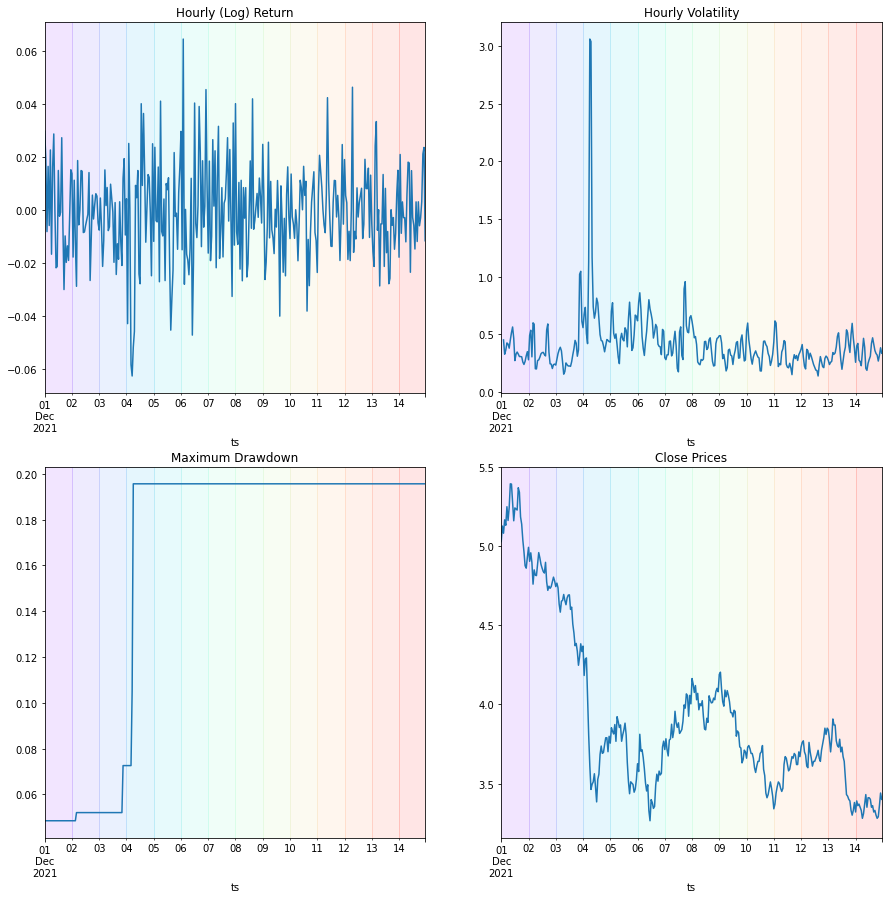

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

series_plot(prices['return'],ax=ax[0,0])
ax[0,0].title.set_text('Hourly (Log) Return')

series_plot(prices['volatility'],ax=ax[0,1])
ax[0,1].title.set_text('Hourly Volatility')

series_plot(prices['max_drawdown'],ax=ax[1,0])
ax[1,0].title.set_text('Maximum Drawdown')

series_plot(prices['close'],ax=ax[1,1])
ax[1,1].title.set_text('Close Prices')


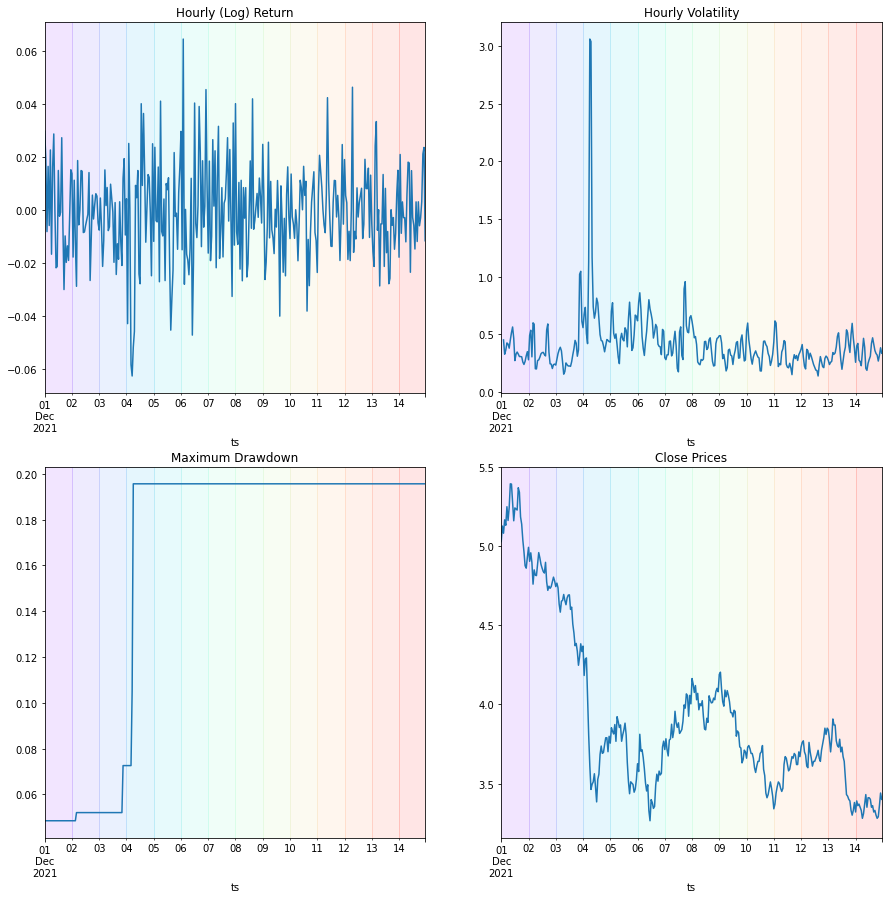

In [11]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)

In [12]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,volatility,return,drawdown,max_drawdown
ts,,,,,,,,,,,,
2021-12-01 00:00:00,4.8830,5.0723,4.8264,5.0295,339580.96,1.693180e+06,CRV,ETH,NaN,0.029561,0.048479,0.048479
2021-12-01 01:00:00,5.0311,5.2000,5.0000,5.1277,764729.41,3.912297e+06,CRV,ETH,NaN,0.019019,0.038462,0.048479
2021-12-01 02:00:00,5.1245,5.1463,5.0352,5.0824,236376.18,1.203741e+06,CRV,ETH,0.450748,-0.008249,0.021588,0.048479
2021-12-01 03:00:00,5.0830,5.1744,5.0438,5.1669,202554.09,1.031154e+06,CRV,ETH,0.326804,0.016371,0.025240,0.048479
2021-12-01 04:00:00,5.1634,5.1754,5.0575,5.1328,192312.10,9.850135e+05,CRV,ETH,0.362358,-0.005944,0.022781,0.048479
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 19:00:00,3.2900,3.3200,3.2600,3.2800,133194.65,4.386547e+05,CRV,ETH,0.319425,-0.003044,0.018072,0.195640
2021-12-14 20:00:00,3.2800,3.3200,3.2700,3.2900,139451.07,4.601693e+05,CRV,ETH,0.267732,0.003044,0.015060,0.195640
2021-12-14 21:00:00,3.2900,3.3900,3.2900,3.3600,152181.31,5.078596e+05,CRV,ETH,0.317222,0.021053,0.029499,0.195640
